
# Lecture 6: Multicollinearity (Completed version)

In th coming two lectures, we will focus on model misspecification issues (How to design a good regression model?).

  Today, we start with **multicollinearity**.

**Overview**

- Understand what **multicollinearity** is (perfect vs near)

- How to **diagnose** it (correlations, VIF, condition number)

- What it **does to OLS** (unbiased but **imprecise**; large SEs; unstable signs)

- How to **address** it 


> 🔑 Key idea: 
> - Multicollinearity means some regressors carry (almost) the **same information**.  
> - This makes it hard to **separate out** their individual effects.
> - OLS can still predict well, but **individual coefficients** can be **noisy/fragile**.

---

## 🌱 Warm-up — Connecting to last week

- Last week, we learned how to **incorporate qualitative data** into regression using **dummy variables**.  

- For example, coding **Yes = 1** and **No = 0** for a survey response or treatment indicator (e.g., whether someone received a new drug).  

- We also mentioned the **dummy variable trap** — a special case of **multicollinearity**.

<hr style="border: 1px dotted #bbb;">

### Step-by-step: where multicollinearity appears

1️⃣ **Set up a model that triggers the trap** — we include both dummies *and* an intercept:
$$
y_i = \beta_0 + \beta_1\,\text{Yes}_i + \beta_2\,\text{No}_i + u_i
$$

<hr style="border: 1px dotted #bbb;">

2️⃣ **But every observation is either Yes or No**, so: for each individual $i$, it must be true that
$$
\text{Yes}_i + \text{No}_i = 1
$$

- One regressor is an **exact linear combination** of the others (We can write one as a linear function of the others: 

    - In this case, $\text{No}_i = 1 - \text{Yes}_i$.  

- That’s **perfect multicollinearity**.

<hr style="border: 1px dotted #bbb;">

3️⃣ **Rewrite the fitted value** using $\text{No}_i = 1 - \text{Yes}_i$:
$$
\hat{y}_i
= \hat{\beta}_0 + \hat{\beta}_1\,\text{Yes}_i + \hat{\beta}_2\,(1-\text{Yes}_i)
= (\hat{\beta}_0 + \hat{\beta}_2) + (\hat{\beta}_1 - \hat{\beta}_2)\,\text{Yes}_i
$$

<hr style="border: 1px dotted #bbb;">

4️⃣ **Key consequence — no unique coefficients.**  
Only the **two combinations** matter:
$$
A = \hat{\beta}_0 + \hat{\beta}_2, \qquad
B = \hat{\beta}_1 - \hat{\beta}_2.
$$
Any triple $(\hat{\beta}_0,\hat{\beta}_1,\hat{\beta}_2)$ that keeps $A$ and $B$ the same gives **identical $\hat y$**.

<hr style="border: 1px dotted #bbb;">

5️⃣ **Concrete numeric example.**  
If one valid set is
$$
(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2) = (10, 2, 4),
$$
then all of the following produce **the same predictions**:
- $(9, 3, 5)$
- $(8, 4, 6)$
- $(7, 5, 7)$
- $(6, 6, 8)$

because each keeps  
$$
A = \beta_0+\beta_2 = 14, B = \beta_1-\beta_2 = -2
$$

<hr style="border: 1px dotted #bbb;">

> ⚠️ **Identification fails:** OLS cannot uniquely determine $\beta_0,\beta_1,\beta_2$ here.  
>
> All those parameter sets give the same fitted values.

✅ **Fix:** Drop one dummy (say, *No*) so the remaining dummy measures the effect *relative to the omitted group*.


<hr style="border: 1px dotted #bbb;">

### Two types of multicollinearity

- **Perfect multicollinearity:**  

  An exact linear relationship among regressors (e.g., \(x_3 = 2x_1 - x_2\)).  

  → The model has **no unique OLS solution** — as we saw in the dummy variable example, many sets of coefficients fit the data equally well.

- **Near multicollinearity:**  

  Variables are highly, but not perfectly, correlated.  

  → OLS can still compute estimates, but they become **unstable** —  

  small changes in the data can lead to **large swings** in estimated coefficients or even **sign reversals**.

> 💡 “Unstable” here means the model still runs, but its coefficient estimates are very sensitive:  
> if we slightly change the sample or add one more observation, the signs or magnitudes of $\hat{\beta}_j$ may change dramatically.





---


## 📦 Required libraries

In [1]:

# Install quietly if needed
!pip install numpy pandas statsmodels matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

rng = np.random.default_rng(2024)


---


## 🎯 Tiny Toy Dataset — used in all sections

<div align="center">

| Variable | Symbol | Description |
|:----------|:-------:|:------------|
| Education | $x_1$ | Years of education |
| Experience | $x_2$ | Years of experience |
| Noisy education | $x_3$ | A slightly noisy copy of education: $x_3 = x_1 + \text{small noise}$ → **highly collinear** with $x_1$ |

</div>

> **Real-world analogs for $x_3$:**  
> • “Highest degree measured in years” (e.g., BA=16, MA=18)  
> • “Total credits earned” (highly correlated with years of education)

<hr style="border: 1px dotted #bbb;">

**Data-generating process (DGP):**

$$
y_i = 5 + 1.2\,x_{1i} + 0.8\,x_{2i} + \varepsilon_i, 
\qquad 
\varepsilon_i \sim \mathcal{N}(0,\,2^2)
$$

> 🔎 **Expectation:**  
> - Adding $x_3$ (a near-duplicate of $x_1$) introduces **near multicollinearity**.  
> - OLS will still run, but:  
>      - SEs for $\hat\beta_1$ and $\hat\beta_3$ **inflate**; coefficients become **unstable**.  
>      - Overall $R^2$ is **almost unchanged** (the same signal is being split across $x_1$ and $x_3$).


In [2]:
# Simulate/Generate the tiny toy dataset according to the DGP (put it in a function for easy re-use)

def generate_df(n, sigma):
    educ  = rng.integers(10, 25, size=n)           # x1
    exper = rng.integers(0, 50,  size=n)           # x2
    educ_noisy = educ + rng.normal(0, 0.3, size=n) # x3 ~ educ + small noise (random number from N(0, 0.3^2))
    eps = rng.normal(0, sigma, size=n)
    y = 5 + 1.2*educ + 0.8*exper + eps

    df = pd.DataFrame({"y": y, "educ": educ, "exper": exper, "educ_noisy": educ_noisy})
    return df

# Generate a dataset
df = generate_df(n=120, sigma=2.0)

# Show the first few rows
df.head()


,y,educ,exper,educ_noisy
0,40.679646,13,24,13.055783
1,52.964632,20,29,20.053208
2,39.096500,11,27,11.121521
3,35.202449,13,21,13.007568
4,46.015203,14,27,13.465139


---

## 1) First look: correlations and scatter plot between variables

### 🔹 **Pairwise correlations** are a quick way to spot potential multicollinearity.

   The **correlation coefficient** between two variables is defined as:

   $$
   \text{Corr}(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
   $$

   where:
   $$
   \text{Cov}(X, Y) = \frac{1}{n-1}\sum_i (X_i - \bar{X})(Y_i - \bar{Y}),
   $$
   and $\sigma_X$, $\sigma_Y$ are the standard deviations of $X$ and $Y$.

   > 👉 If $|\text{Corr}(X, Y)| \approx 1$, the two variables **move almost the same way** — 
   > they rise and fall together.  
   > In regression terms, they carry **almost the same information**, making it hard for OLS 
   > to tell their effects apart.



In [3]:
# Compute the correlation matrix between the independent variables

corr_matrix = df[["educ", "exper", "educ_noisy"]].corr()
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                educ     exper  educ_noisy
educ        1.000000 -0.077422    0.997485
exper      -0.077422  1.000000   -0.064218
educ_noisy  0.997485 -0.064218    1.000000


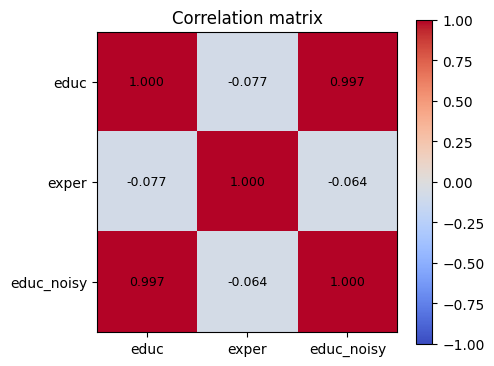

In [4]:
# Visualize the results in a heatmap

plt.figure(figsize=(5,4)) # set figure size
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)

plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns) # x-axis labels
plt.yticks(range(corr_matrix.shape[0]), corr_matrix.index) # y-axis labels

for i in range(corr_matrix.shape[0]): # loop over rows
    for j in range(corr_matrix.shape[1]): # loop over columns
        plt.text(j, i, f"{corr_matrix.values[i,j]:.3f}", ha="center", va="center", fontsize=9)

plt.title("Correlation matrix")
plt.colorbar()
plt.tight_layout()
plt.show()


<hr style="border: 1px dotted #bbb;">

### 🔹 **Scatter plot of $x_1$ vs $x_3$:**

   A near-perfect **straight line** confirms that $x_3$ is essentially (almost) a duplicate of $x_1$.  
   In that case, adding both to OLS gives the model redundant information.

> 💡 **Intuition:** When two regressors move almost identically, OLS struggles to tell their separate effects — the “information content” is overlapping.

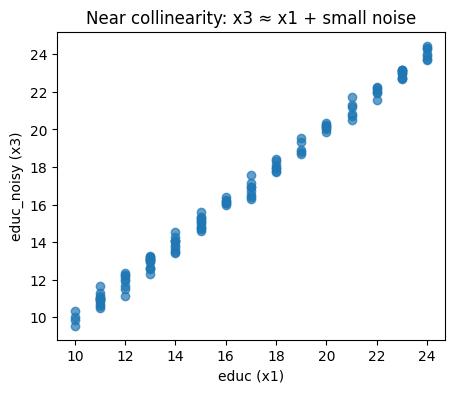

In [5]:
# Plot the scatter of educ vs educ_noisy

plt.figure(figsize=(5,4))
plt.scatter(df["educ"], df["educ_noisy"], alpha=0.7)
plt.xlabel("educ (x1)")
plt.ylabel("educ_noisy (x3)")
plt.title("Near collinearity: x3 ≈ x1 + small noise")
plt.show()

---

## 2) OLS under Multicollinearity: Same Fit, Less Precision (Larger Standard Errors)

We compare two models:

- **Model 1 (no multicollinearity):**
  $$
  y_i = \beta_0 + \beta_1\,\text{educ}_i + \beta_2\,\text{exper}_i + u_i
  $$

- **Model 2 (with multicollinearity):**
  $$
  y_i = \beta_0 + \beta_1\,\text{educ}_i + \beta_2\,\text{exper}_i + \beta_3\,\text{educ\_noisy}_i + u_i
  $$


> 🔎 **Expectation:**  
> • Model 2 will have a **similar $R^2$** (because the new variable adds little new information),  
> • but the **standard errors** for $\hat\beta_1$ and $\hat\beta_3$ will **inflate**,  
> • and their individual estimates will become **unstable** — small data changes can flip signs or magnitudes.

<hr style="border: 1px dotted #bbb;">

### 📐 Reminder: What does $R^2$ measure?

The **$R^2$ statistic** measures how much of the variation in $y$ is explained by the regression model:

$$
R^2 = 1 - \frac{\text{SSR}}{\text{SST}}
$$

where  

$$
\text{SSR} = \sum_i (y_i - \hat{y}_i)^2, \qquad 
\text{SST} = \sum_i (y_i - \bar{y})^2
$$

- **SST (Total Sum of Squares):** total variation in $y$ around its mean  
- **SSR (Sum of Squared Residuals):** unexplained variation after fitting the model  

So $R^2$ measures **overall fit** — not how precisely each coefficient is estimated.

<hr style="border: 1px dotted #bbb;">

### ⚠️ Why multicollinearity is subtle

Even when variables are highly correlated:

- $R^2$ may remain **high** — the model still fits well overall.  
- But OLS struggles to **separate** the effects of correlated regressors, so  

$$
\text{Var}(\hat\beta_j) \text{ becomes large.}
$$  

This leads to:
- big **standard errors**  
- wide **confidence intervals**  
- sometimes even **wrong signs**

> 💡 In short: multicollinearity doesn’t hurt **fit** — it hurts **interpretability**.



In [6]:

# Model 1
X1 = sm.add_constant(df[["educ","exper"]])
m1 = sm.OLS(df["y"], X1).fit()

# Model 2 (adding near-duplicate x3: educ_noisy)
X2 = sm.add_constant(df[["educ","exper","educ_noisy"]])
m2 = sm.OLS(df["y"], X2).fit()

# Display the results
print("Model 1 (no duplicate):")
print(m1.summary().tables[1])
print("\nModel 2 (with near-duplicate x3):")
print(m2.summary().tables[1])

# Compare R^2 values
print("\nR^2 comparison:  M1 =", round(m1.rsquared,4), "  M2 =", round(m2.rsquared,4))


Model 1 (no duplicate):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8864      0.799      6.112      0.000       3.303       6.470
educ           1.2061      0.042     28.482      0.000       1.122       1.290
exper          0.7963      0.013     60.337      0.000       0.770       0.822

Model 2 (with near-duplicate x3):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7616      0.818      5.822      0.000       3.142       6.382
educ           1.6628      0.608      2.736      0.007       0.459       2.866
exper          0.7981      0.013     59.335      0.000       0.771       0.825
educ_noisy    -0.4520      0.600     -0.753      0.453      -1.640       0.736

R^2 comparison:  M1 = 0.973   M2 = 0.9731


> 📘 **Reading the tables:**  
> - In **Model 2**, the coefficients on **educ** and **educ_noisy** become **smaller in magnitude** and have **larger standard errors**  because the model struggles to separate their individual effects.  
>
> - The overall **$R^2$ hardly changes**, meaning the model’s fit to the data is almost the same.  
>
> - We didn’t add new information — we just **split the same signal** across two highly correlated variables.




### Instability: small changes → big swings

- What does *unstable estimation* mean?

- With near collinearity, **tiny data perturbations** can cause **large coefficient swings** while predictions barely change.

---



## 3) Formal Diagnostics: $R_j^2$ and Variance Inflation Factor (VIF)

Now that we’ve seen what collinearity *looks like*, let’s check how we can **formally diagnose** it.

<hr style="border: 1px dotted #bbb;">

### 🔹 Pairwise correlation (recap)
We can start by computing **correlation coefficients** between regressors.  
- High pairwise correlation (say, $|r| > 0.8$) suggests possible overlap.  
- But sometimes, a variable may not be highly correlated with *any single* regressor — yet still be almost explained by a *combination* of them.

That’s why we move beyond pairwise correlations.  

<hr style="border: 1px dotted #bbb;">

### 🔹 The idea of $R_j^2$

For each explanatory variable $x_j$, run an **auxiliary regression** on all the others:

$$
x_j = \alpha_0 + \alpha_1 x_1 + \dots + \alpha_{j-1} x_{j-1} + \alpha_{j+1} x_{j+1} + \dots + u_j
$$

Let $R_j^2$ be the **R-squared** from this regression — the share of variation in $x_j$ that can be explained by *the other regressors*.

- If $R_j^2$ is close to **1**, $x_j$ is almost a linear combination of the others → **severe multicollinearity**.
- If $R_j^2$ is small, $x_j$ adds **unique information**.

<hr style="border: 1px dotted #bbb;">

### 🔹 The link to VIF

The **Variance Inflation Factor (VIF)** for regressor $x_j$ is defined as:

$$
VIF_j = \frac{1}{1 - R_j^2}
$$

Interpretation & **Suggested** principle:   
- $VIF_j = 1$ → no multicollinearity.  
- $VIF_j > 10$ → worrisome degree of collinearity.



In [7]:
# VIFs
X_vif = X2.values
vifs = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

pd.DataFrame({
    "Variable": X2.columns[1:],   # skip const
    "VIF": vifs[1:]              # skip const
})


,Variable,VIF
0,educ,206.388682
1,exper,1.041315
2,educ_noisy,206.001095



> ✅ **Heuristics:** VIFs in the **double digits**  suggest multicollinearity worth addressing.


---


## 5) Some suggested remedies in practice

1) **Re‑specify features:** remove near‑duplicates; combine them (e.g., average or domain index).  
2) **Collect more data** along under‑represented directions.

> 🧭 **Reminder:** Multicollinearity mainly hurts **inference on individual coefficients**. Predictions can still be good, especially if regressors move together out‑of‑sample.

---



## Wrap‑up
  
- Multicollinearity = **overlapping information** across regressors.  

- It **inflates SEs** and makes coefficients **unstable**; OLS remains **unbiased** (assumptions holding).  

- Diagnose with **correlations**, **VIF**.

- Remedies: **re‑specify features**, **collect more data**.



---
## References & Acknowledgments

- This teaching material was prepared with the assistance of **OpenAI's ChatGPT (GPT-5)**.

---

**End of lecture notebook.**